# Prolexitim NLP Analytics
## Predicting TAS-20 from subject text
### Using OpenAI API for embeddings and GPT-based approaches
<hr>

- Prolexitim normalized dataset version Jan23 (from Psicobotica citizen science forms).
- Dataset from Piscobotica Prolexitim TAS-20 Spain instrument and Prolexitim NLP.
- Updated Jan '23, including automated English translation of users' inputs. 

<hr>
Raúl Arrabales Moreno - Updated 4th May 2023 (Psicobótica)<br>

- [conscious-robots.com](http://www.conscious-robots.com/)
- [psicobotica.com](http://www.psicobotica.com/en/)

<hr>

#### This notebook contains:\n",
- Prolexitim dataset loading and checking
- Obtaining OpenAI ADA Embeddings for Card1
- Visualize embeddings related to label Alexithymia
- Explore clustering based on the embeddings
- Visualize different number of clusters
- Explore cluster contents
- Name clusters using OpenAI text-davinci-003
- Discuss clustering details
- Alexithymia Classification using ADA Embeddings



### Helper functions

In [10]:
def get_apikey_from_file(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

### Loading Prolexitim Dataset

In [36]:
import pandas as pd 
import numpy as np

prolexitim_dataset_path = "data/Prolexitim_Jan23_En.csv"
prolexitim_df = pd.read_csv(prolexitim_dataset_path,header=0,delimiter=",")

In [3]:
prolexitim_df.sample(5)

,Timestamp,TAS20,F1,F2,F3,Gender,Age,Code,Alexithymia,Timestamp (1),...,Depression,BAI,Anxiety,PSS,AN,AP,Text_Card1_en,Text_Card9VH_en,Text_Card11_en,Text_Card13HM_en
167,2021-03-02T15:18:19.781Z,77,31,21,25,2,31,20850840d662dd622d0954cc665ac1fa,POSITIVE,2021-03-02T15:23:36.144Z,...,UNKNOWN,NaN,UNKNOWN,NaN,NaN,NaN,... The boy doesn't want to play the violin,... The men on the battlefield are dead,...There is a vulture on a rocky cliff waiting...,... The man killed the woman unintentionally a...
908,2022-04-26T04:01:09.648Z,75,30,22,23,2,20,85440806db36c87d4e5ff39351a67702,POSITIVE,2022-04-26T04:10:36.656Z,...,POSITIVE,47.0,POSITIVE,34.0,NaN,NaN,"That is, without a doubt, the disappointed loo...",The day had been exhausting for all the worker...,The war is over and all that remains are the r...,Along with the night came the departure of the...
998,2022-11-06T04:05:15.752Z,77,29,20,28,2,18,6a554e43beb267376f3ee3c98df3d6e5,POSITIVE,2022-11-06T04:09:15.529Z,...,POSITIVE,41.0,POSITIVE,42.0,30.0,17.0,...\nA boy who was forced to study hard and pl...,...\nAn invasion of rats in which people had t...,"...\nA jungle, a bird on the edge of a cliff w...","...\nA married couple in the morning, the man ..."
694,2021-10-03T19:32:30.266Z,91,34,25,32,2,18,236a07c3853c6e68c9fc08e35f0cf179,POSITIVE,2021-10-03T19:47:40.631Z,...,POSITIVE,NaN,UNKNOWN,49.0,22.0,28.0,"...\na boy wanted to be a violinist, he always...","... a man was surrounded by his best friends, ...",...a bored girl from her family went to the mo...,"... a man, he thought he was in love, but he w..."
448,2021-05-17T07:07:57.660Z,71,22,24,25,2,20,20e00639682765451f9b709a9ebeb4f8,POSITIVE,2021-05-17T07:33:41.708Z,...,UNKNOWN,NaN,UNKNOWN,NaN,NaN,NaN,Once upon a time there was a boy who wanted to...,Many men in war enjoy a moment of peace sleepi...,The waterfall of the nymph where she had her h...,This man is cheating on his wife for a long ti...


In [4]:
prolexitim_df.columns

Index(['Timestamp', 'TAS20', 'F1', 'F2', 'F3', 'Gender', 'Age', 'Code',
       'Alexithymia', 'Timestamp (1)', 'DateDiff_TAS20_NLP', 'Text_Card1',
       'Text_Card9VH', 'Text_Card11', 'Text_Card13HM', 'Text_AllCards', 'PHQ9',
       'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'Depression',
       'BAI', 'Anxiety', 'PSS', 'AN', 'AP', 'Text_Card1_en', 'Text_Card9VH_en',
       'Text_Card11_en', 'Text_Card13HM_en'],
      dtype='object')

In [5]:
# Reduced dataset for alexithymia binary classification (Spanish)
alex_bin_es_df = prolexitim_df[['Code','Alexithymia',
                                'Text_Card1','Text_Card9VH', 
                                'Text_Card11', 'Text_Card13HM', 
                                'Text_AllCards']]

In [6]:
alex_bin_es_df.sample(5)

,Code,Alexithymia,Text_Card1,Text_Card9VH,Text_Card11,Text_Card13HM,Text_AllCards
971,66f49551884b2adcbe9d05e3738d8450,POSITIVE,... \nUn niño sentado en su banco de estudio....,... \nUn grupo de trabajadores aprovechando s...,... \nUn camino de tierra que te lleva a una ...,... \nUn hombre despidiendo a su esposa despu...,... \nUn niño sentado en su banco de estudio....
989,da8c3d15e1caab6a2f4aa4e4bdca9ad3,POSITIVE,... Un chico que tenía una pasión por el viol...,... \nUn grupo de hombres que eran amigos de ...,... Existió el camino que decían que quitaba ...,un hombre con problemas de ira estaba tratand...,... Un chico que tenía una pasión por el viol...
720,7c2d4a539b7d771671ef745f6558fa4c,POSITIVE,"Había una vez un niño que tenía un sueño, quer...","Un grupo de amigos ivivían en un pueblo, había...","\nNo logro distinguir nada de la imagen, así q...",Había un hombre que era muy borracho y mujerie...,"Había una vez un niño que tenía un sueño, quer..."
521,a5f4f654a0739ba30a1146b5b014a617,POSITIVE,... \nUn niño que estaba frustrado por no sab...,... \nUn soldado dormido junto a sus amigos d...,... \nUna cascada muy bonita,... \nUn hombre que estaba triste por haber a...,... \nUn niño que estaba frustrado por no sab...
613,e716902c617896d0126bca315905483b,POSITIVE,... \nerase una vez un niño que le gustaba mu...,... \nunos hombres que estaban exhaustos de t...,... no logró identificar para nada la imagen\n,... \nUn hombre tiene que ir a trabajar despu...,... \nerase una vez un niño que le gustaba mu...


In [9]:
# It's quite unbalanced (Let's keep it that way for the time being)
alex_bin_es_df.value_counts('Alexithymia')

Alexithymia
POSITIVE    781
NEGATIVE    230
Name: count, dtype: int64

### Build OpenAI Embeddings

In [15]:
# My OpenIA API Key
import openai
import os

os.environ["OPENAI_API_KEY"] = get_apikey_from_file('ram_openai_apikey.txt')

In [13]:
# Using the text-embedding-ada-002 model
# See: https://openai.com/blog/new-and-improved-embedding-model

def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

In [26]:
# Delayed call to prevent this error:
# RateLimitError: Rate limit reached for default-global-with-image-limits in organization on requests per min. 
# Limit: 60 / min. Please try again in 1s. Contact us through our help center at help.openai.com if you continue to have issues. 
import time

def delayed_get_embedding(text, model, delay=1.0):
    time.sleep(delay)
    return get_embedding(text, model)

In [18]:
# Test the API
embed1 = get_embedding('Prueba de texto número uno')
embed1[0:5]

[-0.010036744177341461,
 -0.006101734936237335,
 -0.0021321496460586786,
 0.0005581457517109811,
 0.003024524310603738]

In [28]:
# Test the delayed API +call
embed2 = delayed_get_embedding('Prueba de texto número dos con retardo','text-embedding-ada-002', 0.1)
embed2[0:5]

[-0.03275999426841736,
 -0.013665752485394478,
 -0.009965736418962479,
 0.006113803945481777,
 0.004797192290425301]

In [31]:
# Adding the ADA embedding for Card1 text (one per second)
alex_bin_es_df['ada_card1'] = alex_bin_es_df['Text_Card1'].apply(lambda x: delayed_get_embedding(x, model='text-embedding-ada-002',delay=1.0))

/tmp/ipykernel_22351/3072694236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alex_bin_es_df['ada_card1'] = alex_bin_es_df['Text_Card1'].apply(lambda x: delayed_get_embedding(x, model='text-embedding-ada-002',delay=1.0))


In [32]:
alex_bin_es_df.sample(5)

,Code,Alexithymia,Text_Card1,Text_Card9VH,Text_Card11,Text_Card13HM,Text_AllCards,ada_card1
68,1e72525d8fb4f267c045e14d55640ad4,POSITIVE,Erase una vez un niño que odiaba ir a clases d...,"Había sido una dura jornada de trabajo, más in...",Aprovechó los túneles de una antigua mina aban...,"No quería irse todavía, pero llegaba tarde al ...",Erase una vez un niño que odiaba ir a clases d...,"[-0.010896380990743637, 0.0089723477140069, 0...."
830,950b4cc4250f382566f349f11baac775,POSITIVE,Se durmió del aburrimiento porque su juguete o...,Un tipo se rindió acerca de la vida así que ya...,Es un bosque abandonado porque era raro y no t...,Un tipo mata a su esposa mientras estaba enfer...,Se durmió del aburrimiento porque su juguete o...,"[-0.019900325685739517, -0.004587495233863592,..."
594,61419c2148689318e050711b3239a679,POSITIVE,... \nun niño que estaba en su casa estudiand...,... \nunos hombres que estaban bebiendo y se ...,... \nunas personas que estaban migrando de s...,... \nun hombre que llegaba a su casa cansado...,... \nun niño que estaba en su casa estudiand...,"[-0.022362470626831055, 0.011275142431259155, ..."
565,55814527e81fba16e0f5c4f2e2e43c53,POSITIVE,That child is feeling sad because he doesn't k...,Everyone is just lazy............................,i dont understand this picture...................,The man had sex with the lady and then killed ...,That child is feeling sad because he doesn't k...,"[-0.0062584769912064075, 0.007839887402951717,..."
989,da8c3d15e1caab6a2f4aa4e4bdca9ad3,POSITIVE,... Un chico que tenía una pasión por el viol...,... \nUn grupo de hombres que eran amigos de ...,... Existió el camino que decían que quitaba ...,un hombre con problemas de ira estaba tratand...,... Un chico que tenía una pasión por el viol...,"[-0.04239550977945328, 0.005835925228893757, 0..."


In [33]:
# Save to file
alex_bin_es_df.to_csv('output/alex_bin_es_ada.csv', index=False)

In [37]:
# Read it back to mem:
embeds_df = pd.read_csv('output/alex_bin_es_ada.csv')
embeds_df['ada_card1'] = embeds_df.ada_card1.apply(eval).apply(np.array)

In [38]:
embeds_df.sample(5)

,Code,Alexithymia,Text_Card1,Text_Card9VH,Text_Card11,Text_Card13HM,Text_AllCards,ada_card1
780,fe9e6c51a836d1a7e0f276e9baf1174c,POSITIVE,un niño estresado por algo que sentía que no...,"varios hombres aburridos de su rutina, sin n...","un acantilado, muy peligroso, pero en el que...","un chico, el cual se sentía insuficiente por...",un niño estresado por algo que sentía que no...,"[-0.03383832052350044, 0.0004078377387486398, ..."
483,8dec5f595dd7acd55350a16aa11b105d,POSITIVE,"... un niño con un talento brillante, era muy...","... unos campesinos que vivían juntos, todas ...","... un jarrón de oro, el jarrón era de los in...","... un hombre muy trabajador, con un puesto e...","... un niño con un talento brillante, era muy...","[-0.03478597104549408, 0.005945428274571896, 0..."
667,a23f68fa91b47c75921d052084ea0b78,POSITIVE,Erase una vez Un niño que sufria mucho por sus...,Erase una vez... un hombre quetrabajaba en un ...,... \nUn paisaje hermoso pero los humanos lo ...,... \nUn señor asesino a su esposa o murio po...,Erase una vez Un niño que sufria mucho por sus...,"[-0.007756105624139309, 0.008834250271320343, ..."
25,42de991d2161773b17e4666e49b5b197,POSITIVE,... un niño que miraba al violín y no sabia s...,... unos hombres que intentaban dormir al ca...,... unos hombres o mujeres que entraron dentr...,... un hombre y una mujer que han terminado d...,... un niño que miraba al violín y no sabia s...,"[-0.025949135422706604, -0.003094201674684882,..."
784,c8b2c7cdec9d114f9d6d362cc105b6d7,POSITIVE,... un niño que aprendía a tocar el violín. L...,... un grupo de trabajadores que en sus ratos...,...un grupo de aves observan desde una murall...,"...un hombre sufriendo, tal vez arrepentido d...",... un niño que aprendía a tocar el violín. L...,"[-0.027157096192240715, -0.0007798384176567197..."


### Embedding visualization in 2D (t-SNE)

In [49]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib

# Load the embeddings
embeds_df = pd.read_csv('output/alex_bin_es_ada.csv')

# Convert to a list of lists of floats
matrix = np.array(embeds_df.ada_card1.apply(eval).to_list())

Text(0.5, 1.0, 'Alexithymic language visualized in language using t-SNE')

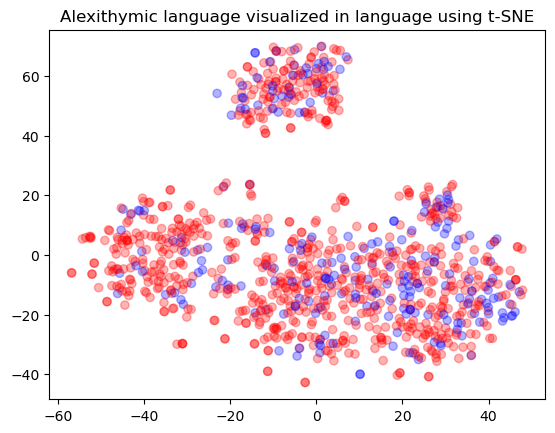

In [50]:
# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

colors = {'POSITIVE':'red', 'NEGATIVE':'blue'}
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = embeds_df['Alexithymia'].apply(lambda x: colors[x])

plt.scatter(x, y, c=color_indices, alpha=0.3)
plt.title("Alexithymic language visualized in language using t-SNE")

As happened with other embedding approaches, there isn't a clear separation between positive and negative alexithymia. However, it looks like we have three different clusters here. It'd be interesting to find out what pattern causes this separation in three grupusculs. 

### Clustering

In [59]:
# Let's recover the other labels before clustering, to check for correlations
labels_and_embeds_df = prolexitim_df.merge(embeds_df)

In [63]:
labels_and_embeds_df.head()

,Timestamp,TAS20,F1,F2,F3,Gender,Age,Code,Alexithymia,Timestamp (1),...,BAI,Anxiety,PSS,AN,AP,Text_Card1_en,Text_Card9VH_en,Text_Card11_en,Text_Card13HM_en,ada_card1
0,2020-06-15T14:35:58.952Z,36,13,8,15,2,50,9048b371b816a38101aa18572090de8c,NEGATIVE,2020-06-15T14:28:25.641Z,...,NaN,UNKNOWN,NaN,NaN,NaN,"Rodrigo, a boy whose parents forced him to stu...","... a group of seasonal workers who, after a l...",... a world inhabited by the strangest animals...,"... A man so dedicated to his work, that he wa...","[-0.008384497836232185, 0.006449613720178604, ..."
1,2020-06-16T15:53:01.414Z,60,27,17,16,2,51,4d40ba4a4b5f87b88ce4ea5c5e226007,NEGATIVE,2020-06-16T16:02:48.020Z,...,NaN,UNKNOWN,NaN,NaN,NaN,a child who wanted to play the violin but his ...,some men who always had dreams and took advant...,a cobbled path where everyone who passed slipp...,"a man in love who, after a frantic night of se...","[-0.017311980947852135, 0.0037717223167419434,..."
2,2020-06-17T12:57:23.074Z,37,16,10,11,1,53,662e3b511b407d83fcc6e41adb79829d,NEGATIVE,2020-06-17T12:54:25.485Z,...,NaN,UNKNOWN,NaN,NaN,NaN,"... a child who watched as the violin, placed ...","... one torrid summer afternoon, men, after a ...","... an impenetrable mountain, lost and inexplo...","... repentance, sated the body's appetite, con...","[-0.017151271924376488, -0.01824740692973137, ..."
3,2020-06-17T23:45:12.244Z,48,14,13,21,1,43,b31c06a8f15da58b30b5198ca52c59ab,NEGATIVE,2020-06-17T23:42:16.710Z,...,NaN,UNKNOWN,NaN,NaN,NaN,a boy who wanted with all his might to play th...,a gang of cowboys that roamed the Arizona plai...,a powerful army camped next to an irreducible ...,"a weak, hesitant and sad man, who decided to g...","[-0.006118627265095711, 0.0007265054737217724,..."
4,2020-06-18T01:22:37.813Z,49,18,13,18,1,50,2ae0c1219a6d2e35dca2f72ef7bc11c3,NEGATIVE,2020-06-18T01:18:04.309Z,...,NaN,UNKNOWN,NaN,NaN,NaN,"... a child who, having more facility for musi...","... a boy who wanted to work and drop out, des...","... on a summer day, specifically August 10, a...",... a government minister who had an affair wi...,"[-0.012190859764814377, -0.002016377169638872,..."


In [68]:
# Let's use KMeans for clustering
from sklearn.cluster import KMeans

# np.array(embeds_df.ada_card1.apply(eval).to_list())
matrix = np.vstack(labels_and_embeds_df.ada_card1.apply(eval).to_list())
matrix.shape

(1139, 1536)

In [162]:
# Explore from 2 to 6 clusters:
for n_clusters in range(2,7):
    kmeans = KMeans(n_clusters = n_clusters, init='k-means++', n_init='auto', random_state=42)
    kmeans.fit(matrix)
    labels_and_embeds_df['clustering_' + str(n_clusters)] = kmeans.labels_

In [164]:
labels_and_embeds_df.sample(4)

,Timestamp,TAS20,F1,F2,F3,Gender,Age,Code,Alexithymia,Timestamp (1),...,Text_Card9VH_en,Text_Card11_en,Text_Card13HM_en,ada_card1,cluster_ada_card1,clustering_2,clustering_3,clustering_4,clustering_5,clustering_6
869,2021-12-04T23:41:04.798Z,58,16,20,22,2,18,fa27abdde5d4cb0f15230bbe4faa510b,NEGATIVE,2021-12-05T00:09:01.167Z,...,"...\na group of soldiers prepared for war, one...",...\na child with a boring and meaningless lif...,...\nan already adult married man but honestly...,"[-0.025755418464541435, 0.0024365829303860664,...",3,0,1,3,3,3
1009,2022-03-19T01:45:42.870Z,84,33,23,28,2,25,c91e98c270460932b271f0f528cd1073,POSITIVE,2022-03-19T02:22:44.876Z,...,...\nA group of researchers has been found in ...,...\nThe secret of the map was discovered by a...,"One night, only one night, he left, he just wa...","[-0.04042232036590576, 0.00922461412847042, 0....",0,0,1,0,0,0
570,2021-05-28T21:24:09.819Z,51,12,19,20,2,23,26cf78d8ce89119796b593ad8ea8d51b,NEGATIVE,2021-05-28T21:29:55.979Z,...,...\nSome tired men after a hard day's work in...,...\nA queen bee fighting a dragon.,"...\nA man accidentally kills his lover, and h...","[-0.023615527898073196, 0.00998577568680048, 0...",0,0,1,0,0,0
819,2021-10-15T02:02:27.190Z,68,27,13,28,2,19,459777225dfd75f8029973c6bb30fc2b,POSITIVE,2021-10-15T02:36:55.159Z,...,A civil war that ended with many men dead on t...,People used to have to escape their cities tha...,"He couldn't contain his crying, seeing his wif...","[-0.009068196639418602, 0.004839248023927212, ...",3,0,1,3,3,3


In [132]:
# how many exemplars per cluster?
labels_and_embeds_df.cluster_ada_card1.value_counts()

cluster_ada_card1
3    391
0    280
1    270
2    198
Name: count, dtype: int64

In [165]:
# Save to file
labels_and_embeds_df.to_csv('output/labels_and_clusters2_6_df.csv', index=False)

In [135]:
# Clusters have no significant difference in alexithymia
labels_and_embeds_df.groupby("cluster_ada_card1").TAS20.mean().sort_values()

cluster_ada_card1
3    65.005115
2    68.813131
0    69.046429
1    70.233333
Name: TAS20, dtype: float64

In [136]:
# Do clusters have any significant difference in depression?
labels_and_embeds_df.groupby("cluster_ada_card1").PHQ9.mean().sort_values()

cluster_ada_card1
0    16.923077
3    17.042105
1    17.352564
2    17.441176
Name: PHQ9, dtype: float64

In [137]:
# Do clusters have any significant difference in anxiety?
labels_and_embeds_df.groupby("cluster_ada_card1").BAI.mean().sort_values()

cluster_ada_card1
0    28.877778
3    29.115183
1    31.245033
2    31.794118
Name: BAI, dtype: float64

In [138]:
# Do clusters have any significant difference in stress?
labels_and_embeds_df.groupby("cluster_ada_card1").PSS.mean().sort_values()

cluster_ada_card1
3    37.132911
2    37.500000
0    37.814286
1    38.756522
Name: PSS, dtype: float64

In [139]:
# Do clusters have any significant difference in negative affect?
labels_and_embeds_df.groupby("cluster_ada_card1").AN.mean().sort_values()

cluster_ada_card1
0    27.941176
2    30.222222
1    30.291139
3    31.093923
Name: AN, dtype: float64

In [140]:
# Do clusters have any significant difference in postive affect?
labels_and_embeds_df.groupby("cluster_ada_card1").AP.mean().sort_values()

cluster_ada_card1
1    22.474684
0    23.184874
3    23.198895
2    24.244444
Name: AP, dtype: float64

### Visualizing clusters

In [178]:
# Visualizing clusters 
def viz_clusters(n_clusters):
    tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
    vis_dims2 = tsne.fit_transform(matrix)

    x = [x for x, y in vis_dims2]
    y = [y for x, y in vis_dims2]
    
    if n_clusters < 7:
        colors = ["purple", "green", "red", "blue", "yellow", "brown"]
    else:
        print('Error: too many clusters.')
        return

    for category, color in enumerate(colors[0:n_clusters]):
        xs = np.array(x)[labels_and_embeds_df['clustering_' + str(n_clusters)] == category]
        ys = np.array(y)[labels_and_embeds_df['clustering_' + str(n_clusters)] == category]
        plt.scatter(xs, ys, color=color, alpha=0.3)

        avg_x = xs.mean()
        avg_y = ys.mean()

        plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)
        plt.annotate('Cluster ' + str(category), (avg_x, avg_y))
    plt.title(str(n_clusters) + " Clusters identified visualized in language 2d using t-SNE")

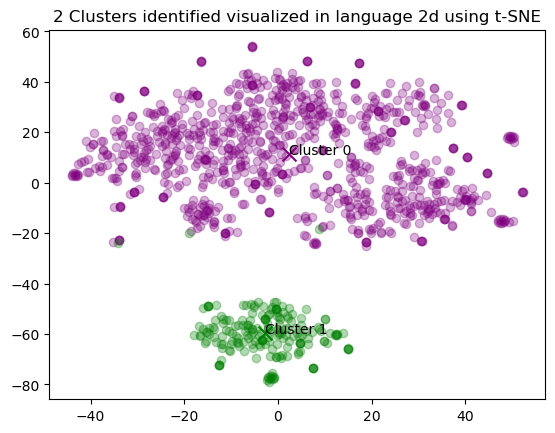

In [179]:
# Visualize all cluster models
viz_clusters(2)

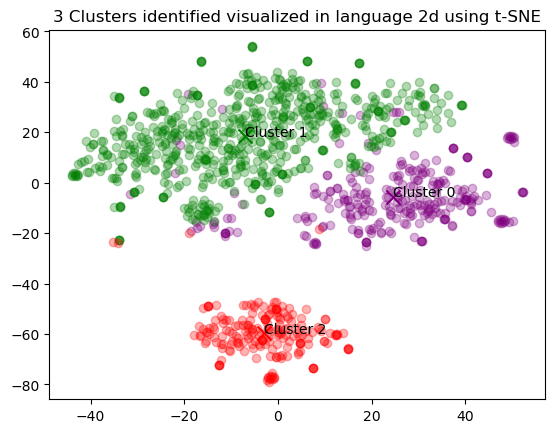

In [180]:
viz_clusters(3)

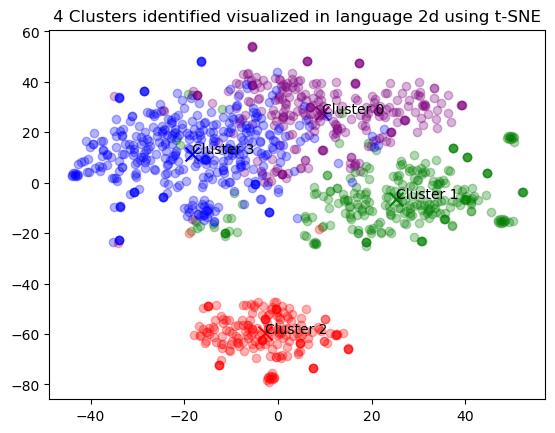

In [181]:
viz_clusters(4)

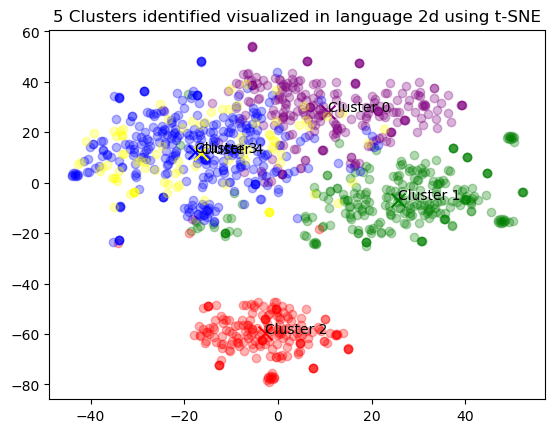

In [182]:
viz_clusters(5)

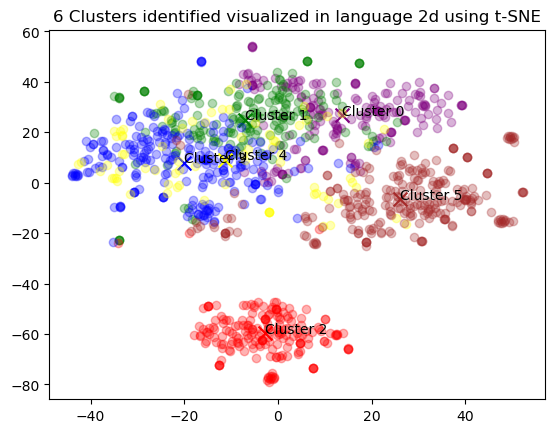

In [183]:
viz_clusters(6)

### Exploring Clusters

Looks like n=4 is a good number of clusters for this experiment (best separation in 2D projection)

In [186]:
for col in labels_and_embeds_df.columns: 
    if 'cluster' in col: 
        print(col)

cluster_ada_card1
clustering_2
clustering_3
clustering_4
clustering_5
clustering_6


In [187]:
labels_and_embeds_df.clustering_4.value_counts()

clustering_4
3    391
0    280
1    270
2    198
Name: count, dtype: int64

In [198]:
regs = labels_and_embeds_df[labels_and_embeds_df.clustering_4 == 2].Text_Card1.sample(6)
for i in regs:
    print(i+'--')

 ... 
Stress cause by over thinking --
The boy doesn't want to play the instrument and it looks like he could also be falling asleep. But it's also possible that he's trying to focus and listen to music an instructor is playing.--
A boy in school is bored looking in the distance not wanting to pay attention in class. Possibly didnt have enough sleep. Music class
--

He has a broken string and cant afford a new o ne he feel sad and doesnt know what to do 
--
a child looking at a violin thinking off what to play, he has brownish hair and is wearing a white tshirt. he is preparing a song for his mother's birthday and wants to surprise her with it--
the child is sad because he is unable to play, he is frustrated because he cannot get if right
--


In [207]:
# Explore random samples from each cluster (from clustering n=4). 
for i in range(4):
    print("Cluster " + str(i) + " samples:\n------------------")
    
    texts = labels_and_embeds_df[labels_and_embeds_df.clustering_4 == i].Text_Card1.sample(6)
    for text in texts:
        sample = '<descripcion>'
        sample += text.replace("\n"," ").replace("...", "").replace("  ", "")
        sample +='</descripcion>'
        print(sample)
        print()
    print()

Cluster 0 samples:
------------------
<descripcion> un niño que estaba triste por no saber tocar un violín, uno de sus instrumentos favoritos, por lo cual esta pensando en recibir clases para lograr sus sueños y poder tocar el violin </descripcion>

<descripcion>un chico fue triste porque no puedé tocar su instrumento. :( </descripcion>

<descripcion>Un niño aburrido y cansado de no avanzar con su aprendizaje con el violín impuesto por sus padres porque,son ellos quien les impone hacerlo,por el hecho de que ellos no pudieron triunfar en su momento y quieren conseguirlo con él </descripcion>

<descripcion> Una chica no sabía que tocar </descripcion>

<descripcion> Un niño que sonaba con tocar el cielo, a través de la música</descripcion>

<descripcion> Un niño que quería tocar el violín pero pensaba y pensaba si tener una melodía en concreto </descripcion>


Cluster 1 samples:
------------------
<descripcion> Un niño pensando </descripcion>

<descripcion>un niño el cuel era obligado a e

In [208]:
# Cluster 2 is formed of English text, let's remove it
clustering_df = labels_and_embeds_df[labels_and_embeds_df.clustering_4 != 2]

In [209]:
clustering_df.clustering_4.value_counts()

clustering_4
3    391
0    280
1    270
Name: count, dtype: int64

Cluster 3: Average lenght: 311.4168797953964
Cluster 1: Average lenght: 152.38518518518518
Cluster 0: Average lenght: 92.01071428571429


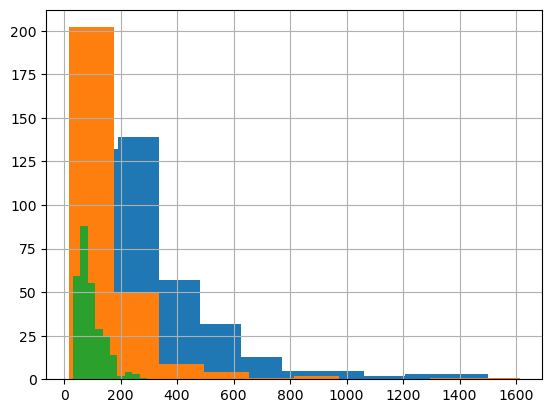

In [289]:
# I suspect at least one cluster is characterized by short texts:
for c in clustering_df.clustering_4.unique():
    print("Cluster " + str(c) + ": ", end="")
    print("Average lenght: " + str(np.mean(clustering_df[clustering_df.clustering_4 == c]['Text_Card1'].str.len())))
    clustering_df[clustering_df.clustering_4 == c]['Text_Card1'].str.len().hist()

### Identifying and naming clusters

In [ ]:
# Then use text-davinci-003 to name the clusters, based on a random sample of n exemplars from that cluster.

In [237]:
# Prepare the samples
samples = {}
for i in clustering_df.clustering_4.unique(): 
    texts = labels_and_embeds_df[labels_and_embeds_df.clustering_4 == i].Text_Card1.sample(10)
    samplelist = []
    for text in texts:
        sample = '<descripcion>'
        sample += text.replace("\n"," ").replace("...", "").replace("  ", "")
        sample +='</descripcion>\n'
        samplelist.append(sample)
    samples[i] = samplelist

In [238]:
samples.keys()

dict_keys([0, 1, 3])

In [279]:
samples

{0: ['<descripcion>un niño que miraba fijamente a un piano </descripcion>\n',
  '<descripcion>un niño desmotivado con su violín, él lo que quería era tocar el piano</descripcion>\n',
  '<descripcion> Un violin esperando ser tocado y un niño esperando tocarlo</descripcion>\n',
  '<descripcion> Un niño que está triste y aburrido, porque tenía que cumplir con sus lecciones de violín. Pero él realmente no quería tocar el violín, quería salir a jugar.</descripcion>\n',
  '<descripcion>Hay un chico llamado Bob. Le encanta tocar el violín. Hasta que su hermano rompió su violín y ahora lo está mirando. </descripcion>\n',
  '<descripcion> un niño que estaba aburrido y cansado porque no podia tocar el violin, lo que queria era salir a jugar y divertirse bajo los arboles, viendo el sol y el pasto.</descripcion>\n',
  '<descripcion>un niño que miraba fijamente a un piano </descripcion>\n',
  '<descripcion>Un niño que perdió su pasión por la música. </descripcion>\n',
  '<descripcion>Un Niño Que Qu

In [247]:
print(''.join(samples.get(0)))

<descripcion>un niño que miraba fijamente a un piano </descripcion>
<descripcion>un niño desmotivado con su violín, él lo que quería era tocar el piano</descripcion>
<descripcion> Un violin esperando ser tocado y un niño esperando tocarlo</descripcion>
<descripcion> Un niño que está triste y aburrido, porque tenía que cumplir con sus lecciones de violín. Pero él realmente no quería tocar el violín, quería salir a jugar.</descripcion>
<descripcion>Hay un chico llamado Bob. Le encanta tocar el violín. Hasta que su hermano rompió su violín y ahora lo está mirando. </descripcion>
<descripcion> un niño que estaba aburrido y cansado porque no podia tocar el violin, lo que queria era salir a jugar y divertirse bajo los arboles, viendo el sol y el pasto.</descripcion>
<descripcion>un niño que miraba fijamente a un piano </descripcion>
<descripcion>Un niño que perdió su pasión por la música. </descripcion>
<descripcion>Un Niño Que Quería Tocar Un Vilin Pero No Podía Y Decidió Dejar De Tocar </d

In [251]:
# Prepare a prompt
cluster1_samples = ''.join(samples.get(1))
prompt = f'¿Qué tienen en común las siguientes descripciones de una imagen ambigua en la que aparece un niño con un violín?\n\nDescripciones:\n"""\n{cluster1_samples}\n"""'
print(prompt)

¿Qué tienen en común las siguientes descripciones de una imagen ambigua en la que aparece un niño con un violín?

Descripciones:
"""
<descripcion> Un niño que estaba triste porque no tenía inspiración para poder tocar, sentía que le hacia falta algo pero no sabía que</descripcion>
<descripcion> Un niño que siempre estaba deprimido decían que no tenía sentimientos que esa frío,sus padres se separaron y se comunicaban atravez de el, su padre le ponía quejas de su madre al igual que su madre de su padre siempre se enteraba cuando sus papás peleaban y se deprimía por eso hablaba con su madre pero ella le decía que la entendiera pero el no quería entender a nadie quería que lo entendieran a él, quería que todo pasara que pudiera expresar sus sentimientos que no tuviera miedo a salir lastimado cuando los demuestre que sentía miedo al tratar de expresarlos</descripcion>
<descripcion>un niño que estaba haciendo un experimento y descubrio un artefacto que podría ser gran utilidad para las activ

In [256]:
# Check all clusters: 
for c in clustering_df.clustering_4.unique():
    cluster_samples = ''.join(samples.get(c))
    prompt = f'¿Qué tienen en común las siguientes descripciones de una imagen ambigua en la que aparece un niño con un violín?\n\nDescripciones:\n"""\n{cluster_samples}\n"""'

    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=prompt,
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print('Cluster ' + str(c) + ':')
    print(response["choices"][0]["text"].replace("\n", ""))
    print("-" * 100)

Cluster 0:
Todas las descripciones tienen en común que el niño está aburrido y desmotivado con su violín, y que desea tocar el piano en lugar de su violín.
----------------------------------------------------------------------------------------------------
Cluster 1:
Todas las descripciones tienen en común que describen a un niño con un violín que está aburrido, triste o reflexivo.
----------------------------------------------------------------------------------------------------
Cluster 3:
Todas las descripciones tienen en común que se trata de un niño con un violín, y que el niño está experimentando alguna forma de frustración o desmotivación al intentar aprender a tocar el
----------------------------------------------------------------------------------------------------


In [257]:
# Check all clusters: 
for c in [0,1,3]:
    cluster_samples = ''.join(samples.get(c))
    prompt = f'¿Qué tienen en común las siguientes descripciones?\n\nDescripciones:\n"""\n{cluster_samples}\n"""'

    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=prompt,
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print('Cluster ' + str(c) + ':')
    print(response["choices"][0]["text"].replace("\n", ""))
    print("-" * 100)

Cluster 0:
Todas las descripciones tienen en común un niño que no está satisfecho con su situación musical. Está aburrido, desmotivado y deseando tocar un instrumento diferente.
----------------------------------------------------------------------------------------------------
Cluster 1:
Todas las descripciones describen a un niño que está tratando de encontrar una solución a un problema o una forma de expresar sus sentimientos.
----------------------------------------------------------------------------------------------------
Cluster 3:
Todas las descripciones tienen en común el tema del violín. En todas ellas se habla de personas que tienen un violín, intentan aprender a tocarlo, tienen frustración al no log
----------------------------------------------------------------------------------------------------


In [273]:
# Check all clusters at the same time: 
cluster0_samples = ''.join(samples.get(0))
cluster1_samples = ''.join(samples.get(1))
cluster3_samples = ''.join(samples.get(3))

prompt = f'¿Qué diferencia hay entre los tres siguientes grupos de descripciones?\n\
\nDescripciones del grupo 0:\n"""\n{cluster0_samples}\n"""\
\nDescripciones del grupo 1:\n"""\n{cluster1_samples}\n"""\
\nDescripciones del grupo 3:\n"""\n{cluster3_samples}\n"""'

response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=prompt,
    temperature=0,
    max_tokens=512,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
)

print(response["choices"][0]["text"].replace("\n", ""))

Las descripciones del grupo 0 se refieren a un niño que mira un piano o un violín y desea tocarlo, pero no puede. Estas descripciones se centran en la frustración y la tristeza del niño.Las descripciones del grupo 1 se refieren a un niño que está aburrido o triste por alguna razón, pero que está buscando una forma de salir de esa situación. Estas descripciones se centran en la búsqueda de soluciones y la motivación del niño.Las descripciones del grupo 3 se refieren a un niño que quiere aprender a tocar el violín, pero que se enfrenta a dificultades para lograrlo. Estas descripciones se centran en la lucha del niño para superar sus obstáculos y alcanzar su objetivo.


In [275]:
# Check all clusters at the same time: 
cluster0_samples = ''.join(samples.get(0))
cluster1_samples = ''.join(samples.get(1))
cluster3_samples = ''.join(samples.get(3))

prompt = f'Se mostró una imagen ambigua a tres grupos de personas para que describieran lo que ven en la imagen.\
A continuación se incluyen las descripciones que dieron las personas al ver esa misma imagen.\
¿Qué diferencia hay en el procesamiento emocional de las personas de cada grupo?\
\n\
\nDescripciones del grupo 0:\n"""\n{cluster0_samples}\n"""\
\nDescripciones del grupo 1:\n"""\n{cluster1_samples}\n"""\
\nDescripciones del grupo 3:\n"""\n{cluster3_samples}\n"""'

response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=prompt,
    temperature=0,
    max_tokens=512,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
)

print(response["choices"][0]["text"].replace("\n", ""))

En el procesamiento emocional de las personas de cada grupo hay diferencias significativas. El grupo 0 describe la imagen con un enfoque más negativo, centrándose en la tristeza y la frustración del niño. El grupo 1 describe la imagen con un enfoque más positivo, centrándose en la motivación y la esperanza del niño. El grupo 3 describe la imagen con un enfoque más neutral, centrándose en la curiosidad y la incertidumbre del niño.


In [281]:
# Check all clusters at the same time: 
cluster0_samples = ''.join(samples.get(0))
cluster1_samples = ''.join(samples.get(1))
cluster3_samples = ''.join(samples.get(3))

prompt = f'Se mostró una imagen ambigua a tres grupos de personas para que describieran lo que ven en la imagen.\
A continuación se incluyen las descripciones que dieron las personas al ver esa misma imagen.\
¿Qué nivel de alexitimia tienen de las personas de cada grupo? ¿Por qué?\
\n\
\nDescripciones del grupo 0:\n"""\n{cluster0_samples}\n"""\
\nDescripciones del grupo 1:\n"""\n{cluster1_samples}\n"""\
\nDescripciones del grupo 3:\n"""\n{cluster3_samples}\n"""'

response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=prompt,
    temperature=0,
    max_tokens=512,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
)

print(response["choices"][0]["text"].replace("\n", ""))

El nivel de alexitimia de las personas de cada grupo depende de la descripción que hayan dado. Si la descripción es detallada y emocionalmente cargada, entonces el nivel de alexitimia es bajo. Si la descripción es vaga y no contiene muchos detalles emocionales, entonces el nivel de alexitimia es alto. Por ejemplo, el grupo 0 tiene un nivel de alexitimia bajo, ya que sus descripciones son detalladas y emocionalmente cargadas. El grupo 1 tiene un nivel de alexitimia bajo, ya que sus descripciones también son detalladas y emocionalmente cargadas. El grupo 3 tiene un nivel de alexitimia medio, ya que sus descripciones son un poco menos detalladas y emocionalmente cargadas que las del grupo 0 y 1.


### Does GPT explanation makes sense? 

Anyway, clusters seem to be more related to subject's text length, and most of what GPT is saying is hallucination. 

In [276]:
clustering_df.columns

Index(['Timestamp', 'TAS20', 'F1', 'F2', 'F3', 'Gender', 'Age', 'Code',
       'Alexithymia', 'Timestamp (1)', 'DateDiff_TAS20_NLP', 'Text_Card1',
       'Text_Card9VH', 'Text_Card11', 'Text_Card13HM', 'Text_AllCards', 'PHQ9',
       'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'Depression',
       'BAI', 'Anxiety', 'PSS', 'AN', 'AP', 'Text_Card1_en', 'Text_Card9VH_en',
       'Text_Card11_en', 'Text_Card13HM_en', 'ada_card1', 'cluster_ada_card1',
       'clustering_2', 'clustering_3', 'clustering_4', 'clustering_5',
       'clustering_6'],
      dtype='object')

In [271]:
for c in clustering_df.clustering_4.unique():
    avg_tas = np.mean(clustering_df[clustering_df.clustering_4 == c]['TAS20'])
    print(f'Avg TAS20 in cluster {c} is {avg_tas}.')

Avg TAS20 in cluster 0 is 69.04642857142858.
Avg TAS20 in cluster 1 is 70.23333333333333.
Avg TAS20 in cluster 3 is 65.00511508951406.


In [288]:
for c in clustering_df.clustering_4.unique():
    avg_an = np.mean(clustering_df[clustering_df.clustering_4 == c]['AN'])
    avg_ap = np.mean(clustering_df[clustering_df.clustering_4 == c]['AP'])
    print(f'Avg Positive Affect in cluster {c} is {avg_ap}.')
    print(f'Avg Negative Affect in cluster {c} is {avg_an}.')
    print()

Avg Positive Affect in cluster 3 is 23.19889502762431.
Avg Negative Affect in cluster 3 is 31.093922651933703.

Avg Positive Affect in cluster 1 is 22.474683544303797.
Avg Negative Affect in cluster 1 is 30.29113924050633.

Avg Positive Affect in cluster 0 is 23.18487394957983.
Avg Negative Affect in cluster 0 is 27.941176470588236.



### Alexithymia Classification 

In [290]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [291]:
labels_and_embeds_df.columns

Index(['Timestamp', 'TAS20', 'F1', 'F2', 'F3', 'Gender', 'Age', 'Code',
       'Alexithymia', 'Timestamp (1)', 'DateDiff_TAS20_NLP', 'Text_Card1',
       'Text_Card9VH', 'Text_Card11', 'Text_Card13HM', 'Text_AllCards', 'PHQ9',
       'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'Depression',
       'BAI', 'Anxiety', 'PSS', 'AN', 'AP', 'Text_Card1_en', 'Text_Card9VH_en',
       'Text_Card11_en', 'Text_Card13HM_en', 'ada_card1', 'cluster_ada_card1',
       'clustering_2', 'clustering_3', 'clustering_4', 'clustering_5',
       'clustering_6'],
      dtype='object')

In [333]:
labels_and_embeds_df.Alexithymia.value_counts()

Alexithymia
POSITIVE    901
NEGATIVE    238
Name: count, dtype: int64

In [305]:
# Embeddings are stored as a string
print(type(labels_and_embeds_df.ada_card1.values[0]))
print(labels_and_embeds_df.ada_card1.values[0][0:80])

<class 'str'>
[-0.008384497836232185, 0.006449613720178604, 0.028148412704467773, -0.006507085


In [307]:
# A new colum with embeddings as np.array
labels_and_embeds_df["ada_card1_array"] = labels_and_embeds_df.ada_card1.apply(eval).apply(np.array)  

In [309]:
# Check
print(type(labels_and_embeds_df.ada_card1_array.values[0]))
print(labels_and_embeds_df.ada_card1_array.values[0][0:4])

<class 'numpy.ndarray'>
[-0.0083845   0.00644961  0.02814841 -0.00650709]


In [314]:
X_train, X_test, y_train, y_test = train_test_split(
    list(labels_and_embeds_df.ada_card1_array.values), labels_and_embeds_df.Alexithymia, test_size=0.2, random_state=42
)

In [315]:
# train random forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

In [316]:
report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

    NEGATIVE       1.00      0.06      0.11        50
    POSITIVE       0.79      1.00      0.88       178

    accuracy                           0.79       228
   macro avg       0.90      0.53      0.50       228
weighted avg       0.84      0.79      0.71       228



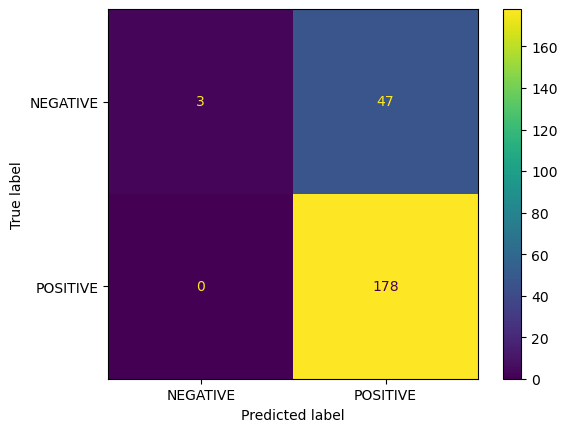

In [324]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.show()

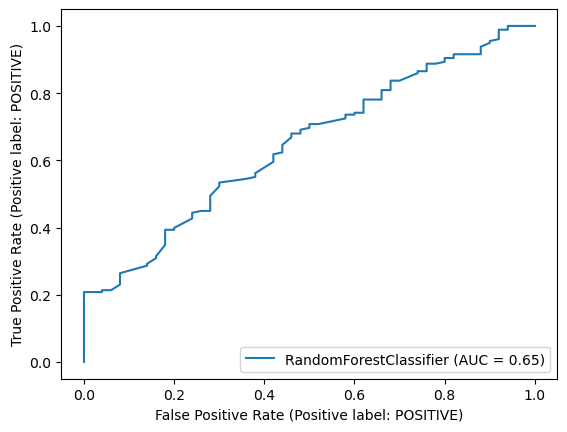

In [329]:
from sklearn.metrics import RocCurveDisplay
svc_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.show()

RandomForestClassifier() - Average precision score over all classes: 0.34


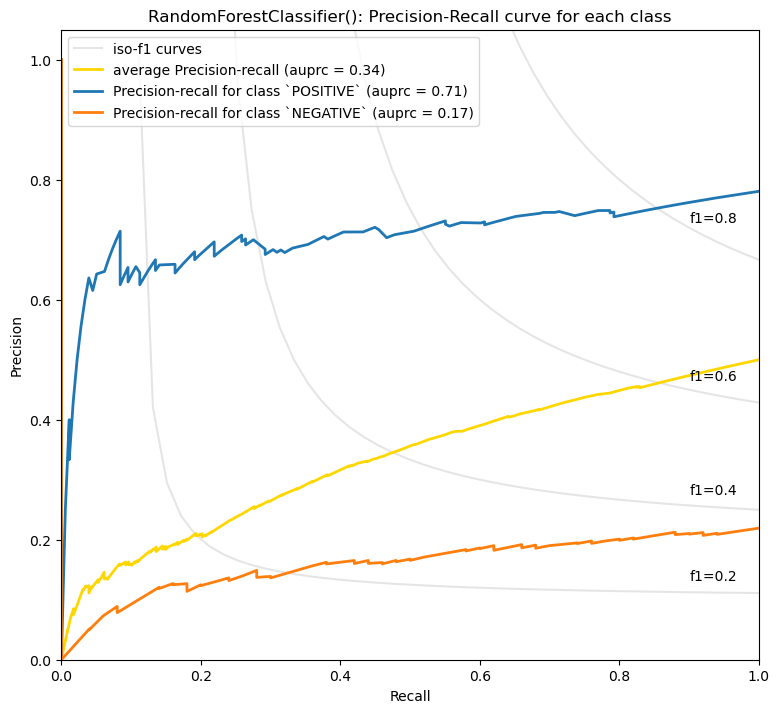

In [323]:
import plotly
from openai.embeddings_utils import plot_multiclass_precision_recall

plot_multiclass_precision_recall(probas, y_test, ['POSITIVE','NEGATIVE'], clf)

In [339]:
# Let's try to compensate for class imbalance

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver = 'newton-cg', class_weight = 'balanced')
lr.fit(X_train, y_train)

preds = lr.predict(X_test)
probas = lr.predict_proba(X_test)

In [340]:
report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

    NEGATIVE       0.29      0.64      0.40        50
    POSITIVE       0.85      0.57      0.68       178

    accuracy                           0.58       228
   macro avg       0.57      0.60      0.54       228
weighted avg       0.73      0.58      0.62       228



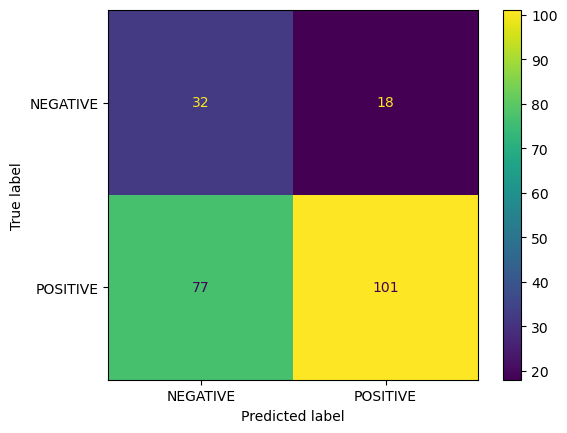

In [341]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)
plt.show()

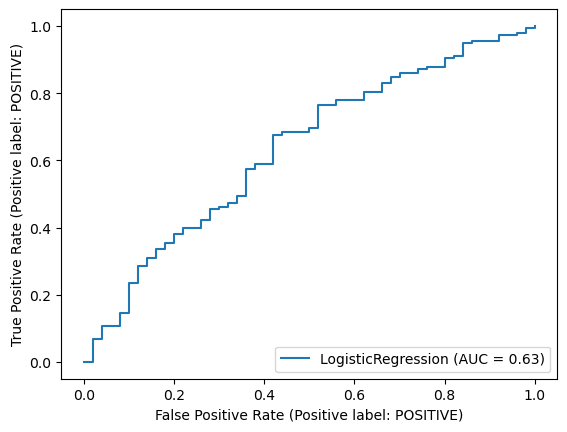

In [342]:
svc_disp = RocCurveDisplay.from_estimator(lr, X_test, y_test)
plt.show()

LogisticRegression(class_weight='balanced', solver='newton-cg') - Average precision score over all classes: 0.42


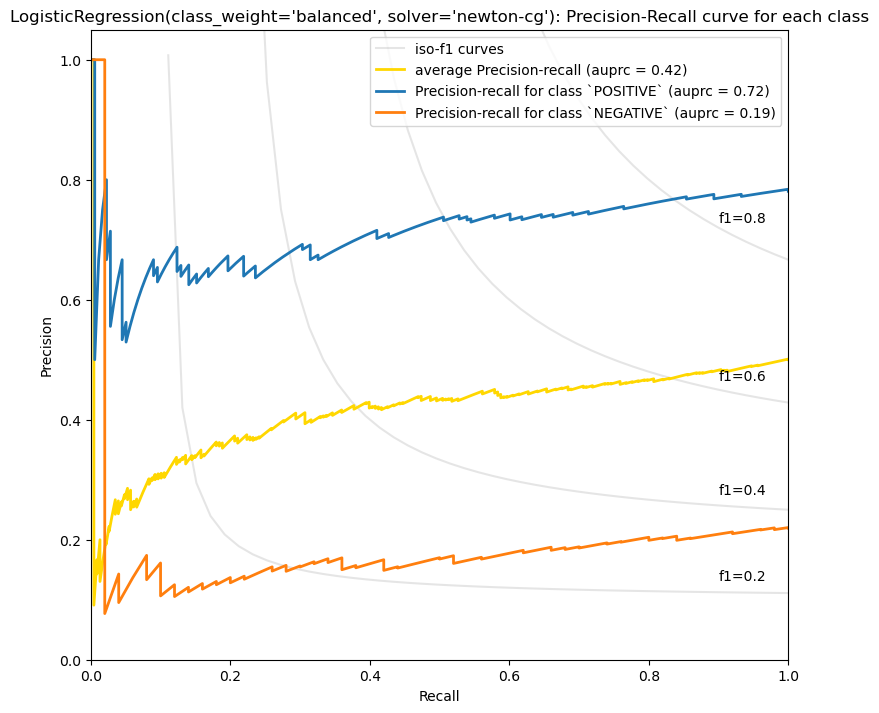

In [343]:
plot_multiclass_precision_recall(probas, y_test, ['POSITIVE','NEGATIVE'], lr)

Looking for the optimal weights to maximize F1 Score

In [373]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

f1_scorer = make_scorer(f1_score, pos_label="POSITIVE")

lr = LogisticRegression(solver='newton-cg')

# Setting the range for class weights
weights = np.linspace(0.0,0.99,100)

# Creating a dictionary grid for grid search
param_grid = {'class_weight': [{'NEGATIVE':x, 'POSITIVE':1.0-x} for x in weights]}

# Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator = lr, 
                          param_grid = param_grid,
                          cv = StratifiedKFold(), 
                          n_jobs = -1, 
                          scoring = f1_scorer,
                          verbose = 2).fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [374]:
weigh_data = pd.DataFrame({ 'F1_Score': gridsearch.cv_results_['mean_test_score'], 'Pos_Class_Weight': 1-weights})

In [375]:
weigh_data.sample(4)

,F1_Score,Pos_Class_Weight
37,0.884944,0.63
78,0.775191,0.22
18,0.884944,0.82
79,0.734698,0.21


Text(0.5, 1.0, 'F1 Score for different class weights')

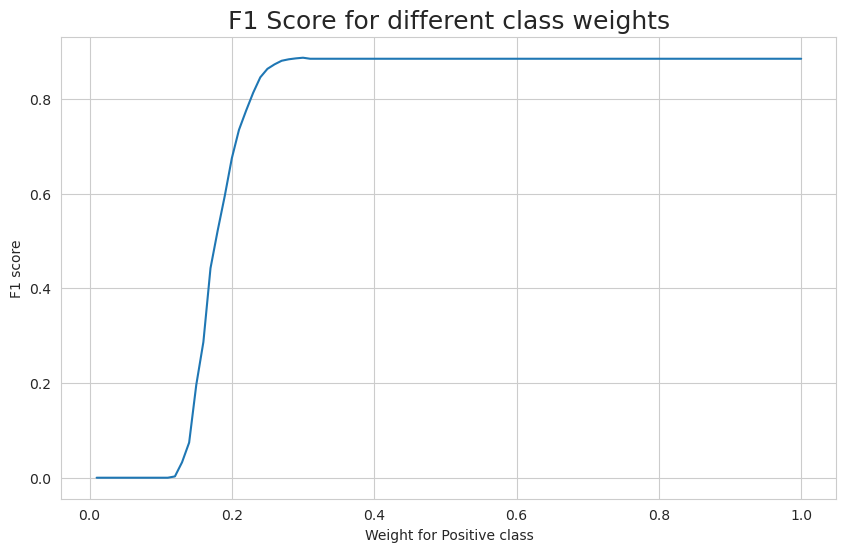

In [379]:
import seaborn as sns

sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.lineplot(data=weigh_data, x='Pos_Class_Weight', y='F1_Score')

plt.xlabel('Weight for Positive class')
plt.ylabel('F1 score')

plt.title('F1 Score for different class weights', fontsize=18)

In [417]:
# Train again the LR with specific weights

lr = LogisticRegression(solver = 'newton-cg', class_weight={'NEGATIVE': 0.8, 'POSITIVE': 0.2})
lr.fit(X_train, y_train)

preds = lr.predict(X_test)
probas = lr.predict_proba(X_test)

In [418]:
report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

    NEGATIVE       0.26      0.66      0.38        50
    POSITIVE       0.83      0.48      0.61       178

    accuracy                           0.52       228
   macro avg       0.55      0.57      0.49       228
weighted avg       0.71      0.52      0.56       228



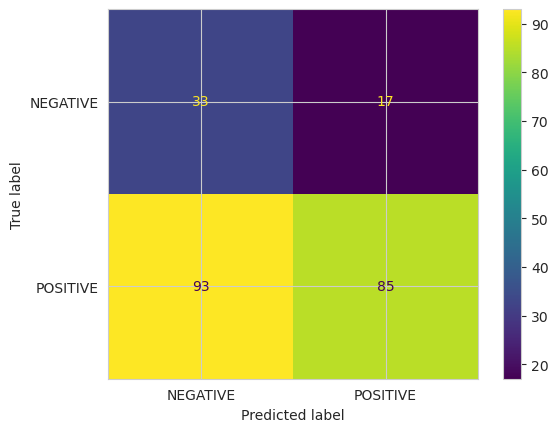

In [419]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)
plt.show()

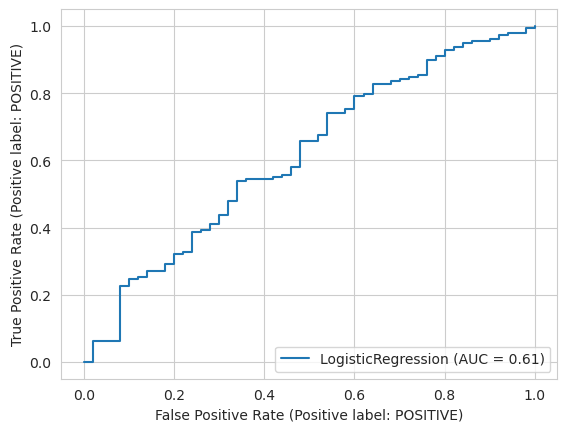

In [420]:
svc_disp = RocCurveDisplay.from_estimator(lr, X_test, y_test)
plt.show()

LogisticRegression(class_weight={'NEGATIVE': 0.8, 'POSITIVE': 0.2},
                   solver='newton-cg') - Average precision score over all classes: 0.47


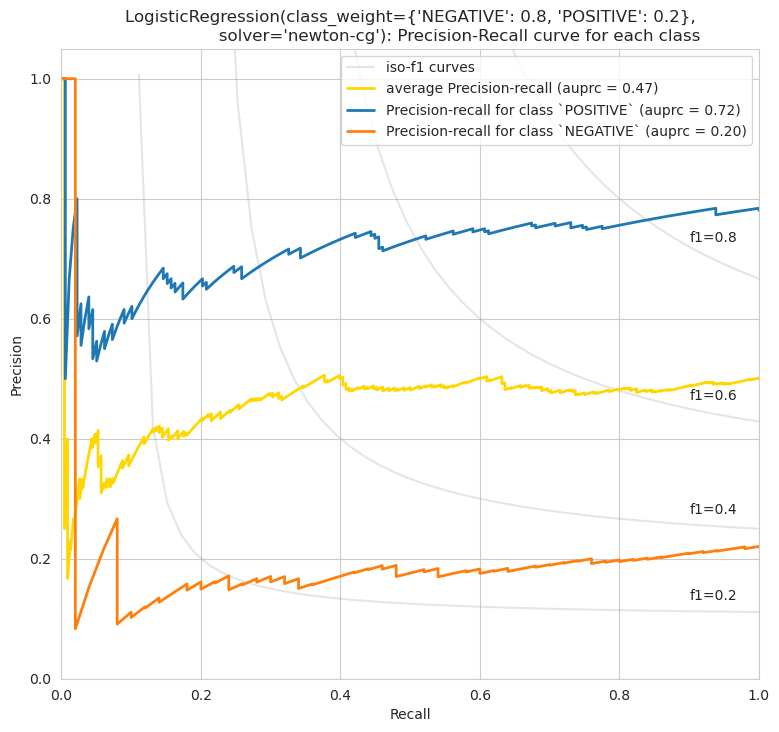

In [421]:
plot_multiclass_precision_recall(probas, y_test, ['POSITIVE','NEGATIVE'], lr)